# Рекомендация тарифов

## Описание проекта

В этом учебном проекте постараемся построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра». Потомучто оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами.
В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф.
Будем искать и строить модель со значением `accuracy` > 0.75.

Для этого протестируем модели классификации с разными гиперпараметрами:
- DecisionTreeClassifier
- RandomForestClassifier
- LogisticRegression
- KNeighborsClassifier
- SVC
- LinearDiscriminantAnalysis

<div class="alert alert-info" role="alert">
    <p class="mb-0">В коде использую <code>display()</code>, потомучто это однозначно даёт понять что планируется вывод / печать результатов. То есть использую <code>display()</code> намеренно, хотя понимаю что можно и без него выводить данные. 👌</p>
</div>

In [1]:
import math

import pandas as pd
import seaborn as sns
# import scipy.stats as st
# import numpy as np
# import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix
from sys import getsizeof

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
# seaborn style via MATPLOTLIBRC
custom_params = {'figure.figsize': (10, 6),
                'figure.facecolor': '#232425',
                'figure.dpi': 240,

                'legend.frameon': False,
                'legend.borderpad': 1.4,
                'legend.labelspacing': 0.7,
                'legend.handlelength': 0.7,
                'legend.handleheight': 0.7,

                'axes.facecolor': '#232425',
                'axes.labelcolor': '#EEEEEE',
                'axes.labelpad': 17,
                'axes.spines.left': False,
                'axes.spines.bottom': False,
                'axes.spines.right': False,
                'axes.spines.top': False,
                'axes.grid': False,

                'contour.linewidth': 0.0,

                'xtick.color': '#AAAAAA',
                'ytick.color': '#AAAAAA',
                'xtick.bottom': True,
                'xtick.top': False,
                'ytick.left': True,
                'ytick.right': False,

                'text.color': '#EEEEEE',
                'font.sans-serif': [
                    'Helvetica',
                    'Verdana',
                    'sans-serif'
                    ]
                }
sns.set_theme(style='darkgrid', rc=custom_params)
sns.set_context("notebook", font_scale=1.37)

In [4]:
random_seed = 108108108

## Откройте файл с данными и изучите его.

In [5]:
try:
    accu_df = pd.read_csv('./datasets/users_behavior.csv')
except FileNotFoundError:
    accu_df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')
    print('FYI csv loaded by url')

In [6]:
display(
    accu_df.sample(5)
)

calls  minutes  messages   mb_used  is_ultra
1854   72.0   515.66      55.0   8890.56         0
737    39.0   248.15       0.0  13443.34         0
5      58.0   344.56      21.0  15823.37         0
2937   50.0   370.49      35.0  21672.13         0
94     78.0   603.91      64.0  18962.50         0

In [7]:
display(
    accu_df.describe()
)

calls      minutes     messages       mb_used     is_ultra
count  3214.000000  3214.000000  3214.000000   3214.000000  3214.000000
mean     63.038892   438.208787    38.281269  17207.673836     0.306472
std      33.236368   234.569872    36.148326   7570.968246     0.461100
min       0.000000     0.000000     0.000000      0.000000     0.000000
25%      40.000000   274.575000     9.000000  12491.902500     0.000000
50%      62.000000   430.600000    30.000000  16943.235000     0.000000
75%      82.000000   571.927500    57.000000  21424.700000     1.000000
max     244.000000  1632.060000   224.000000  49745.730000     1.000000

In [8]:
display(
    accu_df.describe()['calls']['std']
        * 5 + accu_df.describe()['calls']['mean'],
    accu_df.describe()['minutes']['std']
        * 5 + accu_df.describe()['minutes']['mean'],
    accu_df.describe()['messages']['std']
        * 5 + accu_df.describe()['messages']['mean'],
    accu_df.describe()['mb_used']['std']
        * 5 + accu_df.describe()['mb_used']['mean'],
)

229.22073008320368

1611.0581474255894

219.02289731412264

55062.5150675964

С одной стороны, значения что отличаются от среднего больше $5 \times \sigma$ можно бы и отбросить. По каждому тарифу раздельно.
С другой стороны, это может исказить картину для модели…

Оставим до лучших времён…

### Гистограмма Количества Звонков

[Text(0.5, 1.0, 'Звонков в месяц'),
 Text(0.5, 0, 'calls monthly, pcs'),
 Text(0, 0.5, 'count, log')]

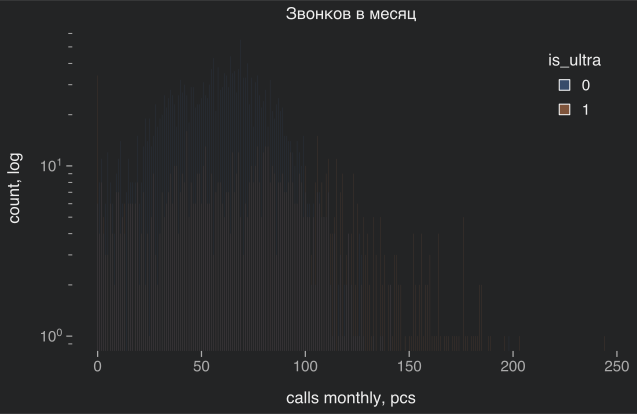

In [9]:
sns.histplot(data=accu_df.loc[: ,['calls', 'is_ultra']],
             bins=len(accu_df['calls'].index),
             color='aquamarine',
             log_scale=(False, True),
             x=accu_df['calls'],
             hue=accu_df['is_ultra']
             ).set(
    title='Звонков в месяц',
    xlabel='calls monthly, pcs',
    ylabel='count, log'
)

### Гистограмма Продолжительности Звонков

[Text(0.5, 1.0, 'Минут в месяц'),
 Text(0.5, 0, 'minutes monthly, min'),
 Text(0, 0.5, 'count, log')]

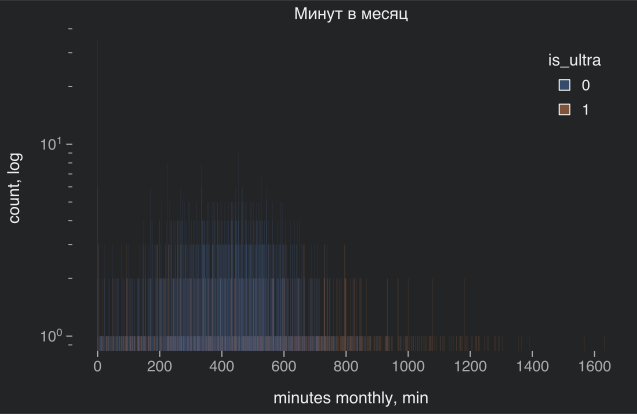

In [10]:
sns.histplot(data=accu_df.loc[: ,['minutes', 'is_ultra']],
             bins=len(accu_df['minutes'].index),
             log_scale=(False, True),
             x=accu_df['minutes'],
             hue=accu_df['is_ultra']
             ).set(
    title='Минут в месяц',
    xlabel='minutes monthly, min',
    ylabel='count, log'
)

### Гистограмма Сообщений

[Text(0.5, 1.0, 'Сообщений в месяц'),
 Text(0.5, 0, 'sms monthly, pcs'),
 Text(0, 0.5, 'count, log')]

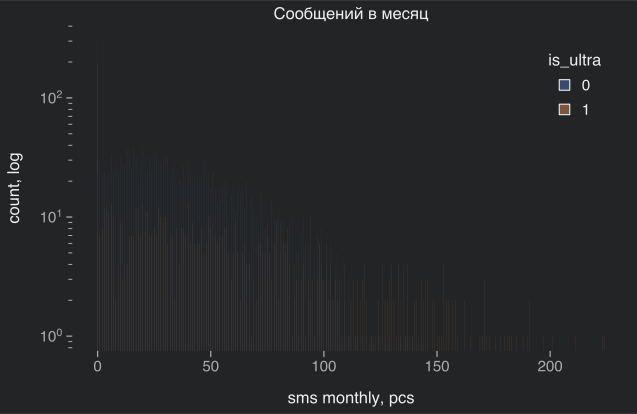

In [11]:
sns.histplot(data=accu_df.loc[: ,['messages', 'is_ultra']],
             bins=len(accu_df['messages'].index),
             log_scale=(False, True),
             x=accu_df['messages'],
             hue=accu_df['is_ultra']
             ).set(
    title='Сообщений в месяц',
    xlabel='sms monthly, pcs',
    ylabel='count, log'
)

### Замена Типов Данных

In [12]:
display(
    accu_df.info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


None

In [13]:
accu_df = accu_df.astype(
    {
        'calls': 'uint8',
        'minutes': 'float32',
        'messages': 'uint8',
        'mb_used': 'float32',
        'is_ultra': 'bool',
    }
)

In [14]:
print(f'Размер набора данных после замены типов данных:',
    round((getsizeof(accu_df) / 1024), 2)
    , 'KB'
)

Размер набора данных после замены типов данных: 34.67 KB


### Соотношение Количества Пользователей Тарифов В Наборе Данных

In [15]:
ultra_users_count = len(accu_df.loc[accu_df['is_ultra'] == True].index)
smart_users_count = len(accu_df.loc[accu_df['is_ultra'] == False].index)
toutal_users = len(accu_df.index)

ultra_users_pc = ultra_users_count / toutal_users
smart_users_pc = smart_users_count / toutal_users

In [16]:
print(
    'Поьзователей Ultra:',
    ultra_users_count
)
print(
    'Поьзователей Smart:',
    smart_users_count
)
print('\nСоотнешение пользователей:')
print('Ultra → {:.2%}'.format(ultra_users_pc))
print('Smart → {:.2%}'.format(smart_users_pc))

Поьзователей Ultra: 985
Поьзователей Smart: 2229

Соотнешение пользователей:
Ultra → 30.65%
Smart → 69.35%


Имеет смысл стратифицировать обучающую, валидационную и тестовую выборки.

## Разделите исходные данные на обучающую, валидационную и тестовую выборки.

In [17]:
features = accu_df.drop(['is_ultra'], axis=1)
target = accu_df['is_ultra']


> Спрятанной тестовой выборки нет. Значит, данные нужно разбить на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов обычно равны. Исходные данные разбивают в соотношении 3:1:1.

©Yandex.Practicum

Используем стандартные пропорции для деления набора данных:
- обучающая выборка 60%
- валидационная выборка 20%
- тестовая выборка 20%


In [18]:
features_train, features_valid,\
target_train, target_valid = train_test_split(
    features, target,
    test_size=0.2,
    shuffle = True,
    random_state=random_seed,
    stratify=target,
)

features_train, features_test,\
target_train, target_test = train_test_split(
    features_train,
    target_train,
    test_size=0.25,
    random_state=random_seed,
    stratify=target_train
)

### Проверим Стратификацию В Выборках

In [19]:
print('x_train', features_train.shape)
print('x_valid', features_valid.shape)
print('x_test', features_test.shape)
print()
print('y train ultra pc: {:.2%}'.format(
          len(target_train.loc[target_train == 1])
          /len(target_train.index)
    )
)
print('y valid ultra pc: {:.2%}'.format(
          len(target_valid.loc[target_valid == 1])
          /len(target_valid.index)
    )
)
print('y test ultra pc: {:.2%}'.format(
          len(target_test.loc[target_test == 1])
          /len(target_test.index)
    )
)


x_train (1928, 4)
x_valid (643, 4)
x_test (643, 4)

y train ultra pc: 30.65%
y valid ultra pc: 30.64%
y test ultra pc: 30.64%


Соотношения выборок похожи на правду 👏

## Исследуем качество разных моделей, меняя гиперпараметры.

### Decision Tree Classifier


Подберём параметры:
- `max_depth`
- `min_samples_leaf`

In [20]:
%%time

best_accu = 0
best_depth = 0
best_leaf_sample = 0

for depth in range(1, 11):
    for leaf_sample in range(1,30):
        tree_model = DecisionTreeClassifier(
            random_state=random_seed,
            max_depth=depth,
            min_samples_leaf=leaf_sample,
        )

        tree_model.fit(features_train, target_train)
        tree_score = tree_model.score(features_valid, target_valid)

        # print('max_depth:', depth,
        #       'leaf sample:', leaf_sample,
        #       '→ {:.3%}'.format(tree_accuracy))

        if tree_score > (best_accu + .00001):
            best_accu = tree_score
            best_depth = depth
            best_leaf_sample = leaf_sample

print('Итог:')
print('\tmax_depth:', best_depth)
print('\tmin_samples_leaf:', best_leaf_sample)
print('\tvalidation_score: {:.3%}'.format(best_accu))
print()

Итог:
	max_depth: 7
	min_samples_leaf: 21
	validation_score: 82.582%

CPU times: user 1.19 s, sys: 5.23 ms, total: 1.19 s
Wall time: 1.19 s


Уже что+то…

<hr>

### Random Forest Classifier


Подберём параметры:
- `max_depth`
- `n_estimators`
- `min_samples_split`
- `min_samples_leaf`

In [21]:
%%time

best_est = 0
best_depth = 0
best_min_sam = 0
best_result = 0
best_leaf_sample = 0

for est in range(1, 11):
    for depth in range(1, 11):
        for min_sam in range(2, 7):
            for leaf_sample in range(1,30):
                forest_model = RandomForestClassifier(
                    random_state=random_seed,
                    n_estimators=est,
                    max_depth=depth,
                    min_samples_split=min_sam,
                    min_samples_leaf=leaf_sample,

                )

                forest_model.fit(features_train, target_train)
                forest_result = forest_model.score(features_valid, target_valid)

                if forest_result > best_result:
                    best_est = est
                    best_depth = depth
                    best_min_sam = min_sam
                    best_result = forest_result
                    best_leaf_sample = leaf_sample
                    # print('n_estimators:', best_est)
                    # print('max_depth:', depth)
                    # print('min_samples_split:', min_sam)
                    # print(round(best_result, 4))

print('Итог:')
print('\tvalidation_score: {:.3%}'.format(best_result))
print('\tn_estimators:', best_est)
print('\tmax_depth:', depth)
print('\tmin_samples_split:', min_sam)
print('\tmin_samples_leaf:', best_leaf_sample)
print()

Итог:
	validation_score: 84.292%
	n_estimators: 1
	max_depth: 10
	min_samples_split: 6
	min_samples_leaf: 12

CPU times: user 2min 37s, sys: 963 ms, total: 2min 38s
Wall time: 2min 38s


Уже что+то… но и времени затрачено 2min 37s…

<hr>

### Logistic Regression


Подберём параметры:
- `solver`
- `max_iter`

In [22]:
log_reg_solvers = ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')
best_lg_solver = None
best_lg_max_iter = 0
best_lg_score = 0

In [23]:
%%time

for lg_solver in log_reg_solvers:
    for lg_iter in range(1000, 20_000, 1000):
        log_reg_model = LogisticRegression(
            random_state=random_seed,
            solver=lg_solver,
            max_iter=lg_iter,
            # fit_intercept=False,
        )

        log_reg_model.fit(features_train, target_train)
        lg_score = log_reg_model.score(features_valid, target_valid)

        if lg_score > (best_lg_score + 0.0001):
            best_lg_solver = lg_solver
            best_lg_max_iter = lg_iter
            best_lg_score = lg_score

/Users/bionic/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/bionic/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/bionic/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/bionic/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/bionic/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/bionic/

CPU times: user 25.5 s, sys: 113 ms, total: 25.6 s
Wall time: 17.7 s


In [24]:
print('Итог:')
print('\tvalidation_score: {:.3%}'.format(best_lg_score))
print('\tsolver:', best_lg_solver)
print('\tmax_iter:', best_lg_max_iter)
print()

Итог:
	validation_score: 75.583%
	solver: newton-cg
	max_iter: 1000



Почти… и предупреждения посыпались…

<hr>

### Support Vector Classifier


Подберём параметры:
- `kernel`
- `max_iter`

In [25]:
svc_kernels = ('linear', 'poly', 'rbf', 'sigmoid')
kernels_with_gamma = ('poly', 'rbf', 'sigmoid')

Пробовал пройтись циклом по разным значениям `gamma` — ячейка отрабатывает очень долго…

In [26]:
%%time

best_svc_kernel = None
best_svc_score = 0

for svc_kernel in svc_kernels:
    svc_model = SVC(
        random_state=random_seed,
        kernel=svc_kernel,
    )
    svc_model.fit(features_train, target_train)
    svc_score = svc_model.score(features_valid, target_valid)
    if svc_score > (best_svc_score + 0.0001):
        best_svc_kernel = svc_kernel
        best_svc_score = svc_score

print('Итог:')
print('\tvalidation_score: {:.3%}'.format(best_svc_score))
print('\tkernel:', best_svc_kernel)
print()

Итог:
	validation_score: 76.050%
	kernel: linear

CPU times: user 3min 10s, sys: 251 ms, total: 3min 11s
Wall time: 3min 11s


Почти…

> ValueError: Precomputed matrix must be a square matrix. Input is a 1928x4 matrix.

Поэтому `Precomputed` kernel не использовал)

<hr>

### K-Nearest Neighbors Classifier


Подберём параметры:
- `n_neighbors`
- `algorithm`


In [27]:
knn_algorithms = ('auto', 'ball_tree', 'kd_tree', 'brute')

In [28]:
%%time

best_knn_algorithms = None
best_knn_n_neighbors = 0
best_knn_score = 0

for knn_algorithm in knn_algorithms:
    for n in range(1, 10):
        knn_model = KNeighborsClassifier(
            n_neighbors=n,
            algorithm=knn_algorithm,
        )
        knn_model.fit(features_train, target_train)
        knn_score = knn_model.score(features_valid, target_valid)

        if knn_score > (best_knn_score + .0001):
            best_knn_algorithms = knn_algorithm
            best_knn_n_neighbors = n
            best_knn_score = knn_score

print('Итог:')
print('\tvalidation_score: {:.3%}'.format(best_knn_score))
print('\tn_neighbors:', best_knn_n_neighbors)
print('\talgorithm:', best_knn_algorithms)
print()

Итог:
	validation_score: 80.093%
	n_neighbors: 7
	algorithm: auto

CPU times: user 1.94 s, sys: 40.2 ms, total: 1.98 s
Wall time: 706 ms


Пойдёт…

<hr>

### Linear Discriminant Analysis

In [29]:
%%time

lda_grid_solver = ('svd', 'lsqr', 'eigen')
best_solver = None
lda_best_score = 0

for solver in lda_grid_solver:
    lin_discr_an_model = LinearDiscriminantAnalysis(
        solver=solver,
    )
    lin_discr_an_model.fit(features_train, target_train)
    lin_discr_an_prediction = lin_discr_an_model.predict(features_valid)
    lda_accu = accuracy_score(lin_discr_an_prediction, target_valid)

    if lda_accu > lda_best_score:
        lda_best_score = lda_accu
        best_solver = solver

print('Итог:')
print('\tvalidation_score: {:.3%}'.format(lda_best_score))
print('\tsolver:', best_solver)
print()

Итог:
	validation_score: 76.672%
	solver: svd

CPU times: user 80.1 ms, sys: 2.64 ms, total: 82.8 ms
Wall time: 15 ms


Пойдёт…

<hr>

### Кратко напишите выводы исследования.

`DecisionTreeClassifier` лучшие найденные гипер+параметры:
- accuracy_score: 82.582%
- max_depth: 7
- min_samples_leaf: 21
- researching time: 1.15 s

`RandomForestClassifier` лучшие найденные гипер+параметры:
- validation_score: 84.292%
- n_estimators: 1
- max_depth: 10
- min_samples_split: 6
- min_samples_leaf: 12
- researching time: 2min 37s

`LogisticRegression` лучшие найденные гипер+параметры:
- validation_score: 75.583%
- solver: newton-cg
- max_iter: 1000
- researching time: 25.6 s

`Support Vector Classifier` лучшие найденные гипер+параметры:
- validation_score: 76.050%
- kernel: linear
- researching time: 3min 11s

`K-Nearest Neighbors Classifier` лучшие найденные гипер+параметры:
- validation_score: 80.093%
- n_neighbors: 7
- algorithm: auto
- researching time: 1.98 s

`Linear Discriminant Analysis`лучшие найденные гипер+параметры:
- validation_score: 76.672%
- solver: svd
- researching time: 82.8 ms


Пока не очень понятно какие модели и для каких данных подходят больше. Какие гиперпараметры нужно крутить, чтобы повысить качество модели…

После применения стратификации `train_test_split(stratify=…)` результаты `score` моделей на валидационной выборке увеличились, но на тестовой выборке `accuracy` едва переваливает за 75%…

`RandomForestClassifier` метод показал лучший результат `score` → 84.292% на валидационной выборке, но, конечно, долго, по сравнению с другими методами классификации…

`Support Vector Classifier` очень долго отрабатывает…

Точность `DecisionTreeClassifier` на тестовых данных: 77.605% — фаворит)

## Проверьте качество модели на тестовой выборке.

Проверим `RandomForestClassifier` на тестовых данных:

Проверим `DecisionTreeClassifier` на тестовых данных:

In [35]:
tree_model = DecisionTreeClassifier(
    random_state=random_seed,
    max_depth=7,
    min_samples_leaf=21,
)
tree_model.fit(features_train, target_train)

tree_predict = tree_model.predict(features_test)
tree_accuracy = accuracy_score(target_test, tree_predict)

print('Точность DecisionTreeClassifier на тестовой выборке: {:.3%}'.format(tree_accuracy))

Точность DecisionTreeClassifier на тестовой выборке: 77.605%


Проверим `KNeighborsClassifier` на тестовых данных:

## Дополнительное задание: проверьте модели на вменяемость.

> Всегда сравнивайте модель со случайной, так вы сможете оценить её адекватность, или проверить на вменяемость (англ. sanity check).

©Yandex.Practicum

### Dummy Classifier

In [38]:
dummy_clf_model = DummyClassifier(strategy='stratified', random_state=random_seed)
dummy_clf_model.fit(features_train, target_train)

dummy_predict = dummy_clf_model.predict(features_test)
dummy_accuracy = accuracy_score(target_test, dummy_predict)

print('Точность DummyClassifier на тестовой выборке: {:.3%}'.format(dummy_accuracy))

Точность DummyClassifier на тестовой выборке: 58.009%


In [39]:
print('{:.3%}'.format(tree_accuracy - dummy_accuracy))

19.596%


Отрыв предсказания `DecisionTreeClassifier` от `DummyClassifier` 19.596%.
Конечно, хотелось бы до 99.999% докрутить)

## Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

`сalls` — количество звонков,
`minutes` — суммарная длительность звонков в минутах,
`messages` — количество sms-сообщений,
`mb_used` — израсходованный интернет-трафик в Мб,
`is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).